In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
pip install timm

# #Res Tiny 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
import copy
import pandas as pd
import time
import os
import timm # Import timm library

# --- Genel Ayarlar ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

NUM_CLIENTS        = 50      # Toplam istemci sayısı
CLIENTS_PER_ROUND  = 10      # Her turda seçilecek istemci sayısı (%20)
NUM_ROUNDS         = 100     # Anlamlı yakınsama için tur sayısı
LOCAL_EPOCHS       = 5       # Yerel eğitim epoch sayısı (1–10 arası denge)
BATCH_SIZE         = 32      # Bellek ve hız dengesi için
LEARNING_RATE      = 1e-3    # AdamW + scheduler ile uyumlu başlangıç değeri
NON_IID_ALPHA      = 0.5     # Orta şiddette heterojenite


# --- 1. Model: ResNet-10 Tiny (CIFAR-10 için uyarlandı) ---

def get_resnet_for_cifar10(model_name='resnet10t', pretrained=False):
    """
    CIFAR-10 için önceden eğitilmemiş/eğitilmiş daha küçük bir ResNet modeli (örn. ResNet-10 Tiny).
    TIMM kütüphanesini kullanarak belirtilen modeli oluşturur ve num_classes=10 ile son katmanı uyarlar.
    """
    print(f"Creating model: {model_name}, pretrained={pretrained}")
    model = timm.create_model(model_name, pretrained=pretrained, num_classes=10)
    return model

# --- 2. Veri Yükleme ve Bölümleme (Önceki gibi ama daha net) ---

def get_cifar10_data():
    """CIFAR-10 veri setini yükler."""
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    return trainset, testset

def partition_data_non_iid(dataset, num_clients, alpha=0.5):
    """Veri setini Dirichlet dağılımı kullanarak Non-IID olarak böler."""
    targets = np.array(dataset.targets)
    num_classes = len(np.unique(targets))
    client_data_indices = [[] for _ in range(num_clients)]
    for k in range(num_classes):
        idx_k = np.where(targets == k)[0]
        np.random.shuffle(idx_k)
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        # Her istemciye en az birkaç örnek düştüğünden emin olmak için ayarlama
        proportions = np.maximum(proportions, 1e-4) # Çok küçük oranları önle
        proportions = proportions / proportions.sum()
        proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
        splits = np.split(idx_k, proportions)
        for i, idx_j in enumerate(splits):
            client_data_indices[i].extend(idx_j.tolist())

    # Karıştır
    for indices in client_data_indices:
        random.shuffle(indices)

    return client_data_indices

def get_client_dataloaders(dataset, client_indices):
    """Her istemci için DataLoader listesi oluşturur."""
    return [DataLoader(Subset(dataset, indices), batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
            for indices in client_indices]

# --- 3. Yeşil Hesaplama Simülasyonu (Önceki gibi) ---

CARBON_INTENSITY_DATA = pd.Series(
    [100, 90, 80, 75, 70, 65, 60, 55, 60, 80, 120, 150,
     180, 200, 220, 210, 190, 170, 150, 130, 120, 110, 105, 100] * 5 # 5 gün
)
def get_carbon_intensity(current_round):
    return CARBON_INTENSITY_DATA[current_round % len(CARBON_INTENSITY_DATA)]

# ResNet-10t'nin parametre sayısı farklı olacaktır, bu yüzden otomatik hesaplanacak.
def estimate_energy_co2(compute_steps, carbon_intensity, model_size_mb):
    KWH_PER_STEP_GPU = 0.00005 # Daha gerçekçi bir tahmin (kalibre edilmeli)
    MB_PER_KWH_COMM = 50        # İletişim maliyeti tahmini (kalibre edilmeli)

    energy_compute = compute_steps * KWH_PER_STEP_GPU
    energy_comm = model_size_mb / MB_PER_KWH_COMM
    total_energy = energy_compute + energy_comm
    co2_grams = total_energy * carbon_intensity
    comm_cost = model_size_mb # Sadece model boyutunu gönderdiğimizi varsayalım
    return total_energy, co2_grams, comm_cost

# --- 4. İstemci ve Sunucu Sınıfları (FL Algoritmaları için) ---

class Client:
    """Temel İstemci Sınıfı."""
    def __init__(self, client_id, train_loader, model_template, lr, device):
        self.id = client_id
        self.loader = train_loader
        self.model = copy.deepcopy(model_template).to(device)
        self.lr = lr
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.capabilities = {'compute': random.uniform(0.7, 1.3), 'network': random.uniform(0.5, 1.5)} # Simüle edilmiş yetenekler

    def train(self, global_model_state, epochs):
        """Temel eğitim fonksiyonu (FedAvg için)."""
        self.model.load_state_dict(global_model_state)
        self.model.train()
        optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
        steps = 0
        for _ in range(epochs):
            for images, labels in self.loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                steps += 1
        return self.model.state_dict(), len(self.loader.dataset), steps

class FedProxClient(Client):
    """FedProx İstemcisi."""
    def __init__(self, client_id, train_loader, model_template, lr, device, mu=0.01):
        super().__init__(client_id, train_loader, model_template, lr, device)
        self.mu = mu

    def train(self, global_model_state, epochs):
        global_model_ref = copy.deepcopy(self.model)
        global_model_ref.load_state_dict(global_model_state)
        global_model_ref.to(self.device)

        self.model.load_state_dict(global_model_state)
        self.model.train()
        optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
        steps = 0

        for _ in range(epochs):
            for images, labels in self.loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                # Proximal Term
                prox_term = 0.0
                for param, global_param in zip(self.model.parameters(), global_model_ref.parameters()):
                    prox_term += ((param - global_param) ** 2).sum()

                loss = loss + (self.mu / 2) * prox_term
                loss.backward()
                optimizer.step()
                steps += 1
        return self.model.state_dict(), len(self.loader.dataset), steps

class SCAFFOLDClient(Client):
    """SCAFFOLD İstemcisi."""
    def __init__(self, client_id, train_loader, model_template, lr, device):
        super().__init__(client_id, train_loader, model_template, lr, device)
        self.control_variate = {name: torch.zeros_like(param) for name, param in self.model.named_parameters()}
        self.server_control_variate = {name: torch.zeros_like(param) for name, param in self.model.named_parameters()}

    def train(self, global_model_state, epochs, server_cv):
        self.model.load_state_dict(global_model_state)
        self.server_control_variate = copy.deepcopy(server_cv)
        self.model.train()
        optimizer = optim.SGD(self.model.parameters(), lr=self.lr) # SCAFFOLD genellikle basit SGD kullanır
        steps = 0
        initial_model_state = copy.deepcopy(self.model.state_dict())
        new_cv = copy.deepcopy(self.control_variate)

        for _ in range(epochs):
            for images, labels in self.loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()

                # SCAFFOLD Grad Modifikasyonu
                with torch.no_grad():
                    for name, param in self.model.named_parameters():
                        if param.grad is not None:
                            param.grad += self.server_control_variate[name] - self.control_variate[name]
                optimizer.step()
                steps += 1

        # İstemci kontrol değişkenini güncelle
        with torch.no_grad():
            K = steps / epochs # Adım sayısı / Epoch (yaklaşık)
            for name, param in self.model.named_parameters():
                new_cv[name] = self.control_variate[name] - self.server_control_variate[name] + \
                               (initial_model_state[name] - param) / (K * self.lr)

        delta_y = {name: self.model.state_dict()[name] - initial_model_state[name] for name in self.model.state_dict()}
        delta_c = {name: new_cv[name] - self.control_variate[name] for name in new_cv}
        self.control_variate = new_cv

        return delta_y, delta_c, len(self.loader.dataset), steps

class Server:
    """Temel FL Sunucusu."""
    def __init__(self, model_template, test_loader, clients, device):
        self.model = copy.deepcopy(model_template).to(device)
        self.test_loader = test_loader
        self.clients = clients
        self.device = device

    def aggregate(self, updates, weights):
        """FedAvg agregasyonu."""
        total_weight = sum(weights)
        global_state = self.model.state_dict()
        for key in global_state:
            global_state[key] = torch.stack([up[key].float() * w for up, w in zip(updates, weights)], 0).sum(0) / total_weight
        self.model.load_state_dict(global_state)
        return global_state

    def evaluate(self):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return 100 * correct / total

class SCAFFOLDServer(Server):
    """SCAFFOLD Sunucusu."""
    def __init__(self, model_template, test_loader, clients, device, lr_global=1.0):
        super().__init__(model_template, test_loader, clients, device)
        self.control_variate = {name: torch.zeros_like(param) for name, param in self.model.named_parameters()}
        self.lr_global = lr_global

    def aggregate(self, delta_ys, delta_cs, weights):
        total_weight = sum(weights)
        avg_delta_y = {name: torch.zeros_like(param) for name, param in self.model.named_parameters()}
        avg_delta_c = {name: torch.zeros_like(param) for name, param in self.model.named_parameters()}

        for key in avg_delta_y:
            avg_delta_y[key] = torch.stack([dy[key].float() * w for dy, w in zip(delta_ys, weights)], 0).sum(0) / total_weight
            avg_delta_c[key] = torch.stack([dc[key].float() * w for dc, w in zip(delta_cs, weights)], 0).sum(0) / total_weight

        # Global modeli güncelle
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                param += self.lr_global * avg_delta_y[name]

        # Global kontrol değişkenini güncelle
        with torch.no_grad():
            for name in self.control_variate:
                self.control_variate[name] += (len(weights) / NUM_CLIENTS) * avg_delta_c[name]

        return self.model.state_dict()


# --- 5. Orkestratörler ---

class RandomOrchestrator:
    """Rastgele İstemci Seçimi (Baseline)."""
    def select_clients(self, all_clients, num_to_select, current_round):
        print(f"  Orchestrator (Random): Selecting {num_to_select} clients.")
        return random.sample(range(len(all_clients)), num_to_select)

class RlOrchestrator:
    """
    Geliştirilmiş Q-Learning Orkestratörü (MetaFed-Vision Simülasyonu).
    MARL'ı simüle eder, tek bir ajan global kararlar alır.
    """
    def __init__(self, num_clients, num_actions, green_aware=True, lr=0.1, gamma=0.9, epsilon=1.0, min_epsilon=0.05, decay=0.99):
        self.num_clients = num_clients
        self.num_actions = num_actions # Burada 'num_actions' yerine, aksiyon uzayını 'istemci setleri' olarak düşünmek daha doğru olur.
                                        # Basitlik adına, 'en iyi N istemciyi seç' gibi bir aksiyon düşünebiliriz.
                                        # Veya Q-tablosunu (State -> Q(Client_i)) olarak kurup en yüksek Q'ya sahip N istemciyi seçebiliriz.
        self.green_aware = green_aware
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = decay
        # State: (Karbon_Seviyesi, Acc_Trendi, Client_Uygunluk_Özeti) -> Q(Client_i)
        self.q_table = {} # {state: {client_id: q_value}}

    def get_state(self, carbon_intensity, acc_history, client_capabilities):
        carbon_level = "low" if carbon_intensity < 100 else ("medium" if carbon_intensity < 200 else "high")
        acc_trend = "up" if len(acc_history) < 2 or acc_history[-1] > acc_history[-2] else "down"
        # İstemci uygunluğunu özetle (örneğin, yüksek işlem gücüne sahip kaç istemci var)
        high_compute_count = sum(1 for c in client_capabilities if c['compute'] > 1.0)
        return (carbon_level, acc_trend, high_compute_count > self.num_clients / 2)

    def choose_clients(self, state, all_clients, num_to_select, client_capabilities, carbon_intensity):
        if random.uniform(0, 1) < self.epsilon:
            # Keşfet: Rastgele seç (ama yeşili biraz düşünerek?)
            print(f"  Orchestrator (RL-Explore): Selecting {num_to_select} clients randomly.")
            return random.sample(range(len(all_clients)), num_to_select), None # Q_values yok
        else:
            # Kullan: Q-tablosuna göre en iyi N istemciyi seç
            q_values_for_state = self.q_table.get(state, {i: 0 for i in range(len(all_clients))})

            # Q değerlerini istemci yetenekleri ve karbona göre biraz daha ayarla (Ad-hoc ama demo için)
            adjusted_q = {}
            for i in range(len(all_clients)):
                base_q = q_values_for_state.get(i, 0)
                compute_factor = client_capabilities[i]['compute']
                # Karbon düşükse, daha güçlü istemcileri tercih et
                carbon_factor = (1 - carbon_intensity / 300) if self.green_aware else 0.5
                adjusted_q[i] = base_q + 0.1 * compute_factor + 0.2 * carbon_factor

            sorted_clients = sorted(adjusted_q.keys(), key=lambda i: adjusted_q[i], reverse=True)
            print(f"  Orchestrator (RL-Exploit): Selecting {num_to_select} clients based on Q-values.")
            return sorted_clients[:num_to_select], adjusted_q

    def update_q_table(self, state, selected_indices, reward, next_state):
        if state is None: return # Keşfetme turunda güncelleme yapma

        # Seçilen her istemci için Q değerini güncelle
        next_max_q = max(self.q_table.get(next_state, {i: 0 for i in range(self.num_clients)}).values()) if self.q_table.get(next_state) else 0

        for client_id in selected_indices:
            old_value = self.q_table.get(state, {}).get(client_id, 0)
            new_value = (1 - self.lr) * old_value + self.lr * (reward + self.gamma * next_max_q)
            if state not in self.q_table:
                self.q_table[state] = {i: 0 for i in range(self.num_clients)}
            self.q_table[state][client_id] = new_value

        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay


# --- 6. Simülasyon Çekirdeği ---

def run_simulation_core(fl_algorithm, orchestrator, clients, server, num_rounds, clients_per_round, use_green, model_param_size_mb):
    accuracies = []
    total_co2_list = []
    total_comm_list = []
    total_co2 = 0
    total_comm = 0
    rl_agent = orchestrator if isinstance(orchestrator, RlOrchestrator) else None
    last_state = None

    for r in range(num_rounds):
        start_time = time.time()
        print(f"\n--- Round {r + 1}/{num_rounds} | FL: {fl_algorithm} | Orch: {type(orchestrator).__name__} ---")

        carbon_now = get_carbon_intensity(r) if use_green else 150

        # A) İstemci Seçimi
        if rl_agent:
            state = rl_agent.get_state(carbon_now, accuracies, [c.capabilities for c in clients])
            selected_indices, q_values = rl_agent.choose_clients(state, clients, clients_per_round, [c.capabilities for c in clients], carbon_now)
            last_state = state # Q güncellemesi için sakla
        else:
            selected_indices = orchestrator.select_clients(clients, clients_per_round, r)

        selected_clients = [clients[i] for i in selected_indices]

        # B) Yerel Eğitim ve Toplama
        updates = []
        delta_cs = [] # SCAFFOLD için
        weights = []
        round_co2 = 0
        round_comm = 0

        global_state = server.model.state_dict()
        server_cv = getattr(server, 'control_variate', None) # SCAFFOLD için

        for client in selected_clients:
            print(f"  Training client {client.id}...")
            if fl_algorithm == 'SCAFFOLD':
                delta_y, delta_c, weight, steps = client.train(global_state, LOCAL_EPOCHS, server_cv)
                updates.append(delta_y)
                delta_cs.append(delta_c)
            else: # FedAvg, FedProx
                update, weight, steps = client.train(global_state, LOCAL_EPOCHS)
                updates.append(update)

            weights.append(weight)
            # Use the adjusted model size for ResNet-10t
            _, co2, comm = estimate_energy_co2(steps, carbon_now, model_size_mb=model_param_size_mb)
            round_co2 += co2
            round_comm += comm * 2 # Hem indirme hem yükleme

        total_co2 += round_co2
        total_comm += round_comm

        # C) Global Agregasyon
        if fl_algorithm == 'SCAFFOLD':
            server.aggregate(updates, delta_cs, weights)
        else: # FedAvg, FedProx
            server.aggregate(updates, weights)

        # D) Değerlendirme
        accuracy = server.evaluate()
        accuracies.append(accuracy)
        total_co2_list.append(total_co2)
        total_comm_list.append(total_comm)
        end_time = time.time()
        round_duration = end_time - start_time
        print(f"  Round {r + 1} - Acc: {accuracy:.2f}% | CO2: {round_co2:.1f}g (Total: {total_co2:.1f}g) | Comm: {round_comm:.1f}MB | Time: {round_duration:.1f}s")

        # E) RL Güncellemesi
        if rl_agent:
            # Ödül: Yüksek doğruluk artışı, düşük CO2 = yüksek ödül
            acc_gain = (accuracies[-1] - accuracies[-2]) * 10 if len(accuracies) > 1 else accuracies[-1]
            co2_penalty = (round_co2 / 100) # Ölçeklendirme önemli
            reward = acc_gain - co2_penalty
            print(f"  RL Reward: {reward:.3f} (AccGain: {acc_gain:.3f}, CO2Penalty: {co2_penalty:.3f})")

            next_carbon = get_carbon_intensity(r + 1) if use_green else 150
            next_state = rl_agent.get_state(next_carbon, accuracies, [c.capabilities for c in clients])
            rl_agent.update_q_table(last_state, selected_indices, reward, next_state)


    return accuracies, total_co2_list, total_comm_list

# --- 7. Ana Simülasyon Yöneticisi ---

def main():
    trainset, testset = get_cifar10_data()
    test_loader = DataLoader(testset, batch_size=BATCH_SIZE * 2, shuffle=False)
    client_indices = partition_data_non_iid(trainset, NUM_CLIENTS, NON_IID_ALPHA)

    # Use the ResNet-10t model for a smaller model
    model_template = get_resnet_for_cifar10(model_name='resnet10t') # Changed model_name to 'resnet10t'

    # Calculate model parameter size in MB
    num_params = sum(p.numel() for p in model_template.parameters() if p.requires_grad)
    model_param_size_mb = num_params * 4 / (1024 * 1024) # Assuming float32 (4 bytes per param)
    print(f"Model (ResNet-10t) has {num_params / 1e6:.2f} M parameters, approx {model_param_size_mb:.2f} MB.")


    scenarios = {
        "FedAvg_ResTiny":       {'algo': 'FedAvg',   'orch': 'Random', 'green': False},
        "FedProx_ResTiny":      {'algo': 'FedProx',  'orch': 'Random', 'green': False},
        "SCAFFOLD_ResTiny":     {'algo': 'SCAFFOLD', 'orch': 'Random', 'green': False},
        "MetaFed_G_ResTiny":    {'algo': 'FedAvg',   'orch': 'Random', 'green': True}, # Ablasyon: Yeşil var, RL yok
    }

    results = {}

    for name, config in scenarios.items():
        print(f"\n\n=======================================")
        print(f"    RUNNING SCENARIO: {name}")
        print(f"=======================================")

        # İstemcileri oluştur
        clients = []
        for i in range(NUM_CLIENTS):
            loader = DataLoader(Subset(trainset, client_indices[i]), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
            if config['algo'] == 'FedProx':
                clients.append(FedProxClient(i, loader, model_template, LEARNING_RATE, DEVICE))
            elif config['algo'] == 'SCAFFOLD':
                clients.append(SCAFFOLDClient(i, loader, model_template, LEARNING_RATE, DEVICE))
            else: # FedAvg
                clients.append(Client(i, loader, model_template, LEARNING_RATE, DEVICE))

        # Sunucuyu oluştur
        if config['algo'] == 'SCAFFOLD':
            server = SCAFFOLDServer(model_template, test_loader, clients, DEVICE)
        else:
            server = Server(model_template, test_loader, clients, DEVICE)

        # Orkestratörü oluştur
        if config['orch'] == 'RL':
            orchestrator = RlOrchestrator(NUM_CLIENTS, CLIENTS_PER_ROUND, green_aware=config['green'])
        else:
            orchestrator = RandomOrchestrator()

        # Simülasyonu çalıştır
        acc, co2, comm = run_simulation_core(
            config['algo'], orchestrator, clients, server, NUM_ROUNDS, CLIENTS_PER_ROUND, config['green'], model_param_size_mb
        )
        results[name] = {'accuracy': acc, 'co2': co2, 'comm': comm}

        # RL Q-tablosunu kaydet (isteğe bağlı)
        if isinstance(orchestrator, RlOrchestrator):
              print(f"RL Q-Table size for {name}: {len(orchestrator.q_table)}")


    # --- 8. Sonuçları Görselleştirme ve Kaydetme ---
    try:
        import matplotlib.pyplot as plt

        fig, axes = plt.subplots(1, 3, figsize=(20, 6))

        # Doğruluk
        ax = axes[0]
        for name, data in results.items():
            ax.plot(data['accuracy'], label=f'{name}')
        ax.set_title('Test Accuracy vs. Rounds')
        ax.set_xlabel('Rounds')
        ax.set_ylabel('Accuracy (%)')
        ax.legend()
        ax.grid(True)

        # CO2 Emisyonları
        ax = axes[1]
        for name, data in results.items():
            ax.plot(data['co2'], label=f'{name}')
        ax.set_title('Cumulative CO2 Emissions vs. Rounds')
        ax.set_xlabel('Rounds')
        ax.set_ylabel('CO2 (g)')
        ax.legend()
        ax.grid(True)

        # İletişim Maliyeti
        ax = axes[2]
        for name, data in results.items():
            ax.plot(data['comm'], label=f'{name}')
        ax.set_title('Cumulative Communication Cost vs. Rounds')
        ax.set_xlabel('Rounds')
        ax.set_ylabel('Communication (MB)')
        ax.legend()
        ax.grid(True)

        plt.tight_layout()
        plt.savefig("metafed_vision_detailed_results_restiny.png") # Changed filename
        print("\nResults plot saved as 'metafed_vision_detailed_results_restiny.png'")
        plt.show()

    except ImportError:
        print("\nMatplotlib not found. Please install it: pip install matplotlib")

    print("\n--- Final Results Summary (Last Round) ---")
    for name, data in results.items():
        print(f"- {name:<15}: Acc = {data['accuracy'][-1]:.2f}% | CO2 = {data['co2'][-1]:.0f}g | Comm = {data['comm'][-1]:.0f}MB")

if __name__ == "__main__":
    main()

Using device: cuda


100%|██████████| 170M/170M [00:16<00:00, 10.1MB/s] 


Creating model: resnet10t, pretrained=False
Model (ResNet) has 4.93 M parameters, approx 18.80 MB.


     RUNNING SCENARIO: MetaFed_RL_G_ResTiny

--- Round 1/100 | FL: FedAvg | Orch: RlOrchestrator ---
  Orchestrator (RL-Explore): Selecting 10 clients randomly.
  Training client 41 (Compute: 1.09)...
  Training client 14 (Compute: 0.85)...
  Training client 12 (Compute: 0.84)...
  Training client 18 (Compute: 1.20)...
  Training client 9 (Compute: 0.95)...
  Training client 8 (Compute: 0.92)...
  Training client 20 (Compute: 1.24)...
  Training client 13 (Compute: 0.98)...
  Training client 37 (Compute: 1.28)...
  Training client 48 (Compute: 1.09)...
  Round 1 - Acc: 23.75% | CO2: 383.4g (Total: 383.4g) | Comm: 375.9MB | Time: 30.8s
  RL Reward: 15.256 (AccGain: 1.188 * 15, CO2Penalty: 2.556)

--- Round 2/100 | FL: FedAvg | Orch: RlOrchestrator ---
  Orchestrator (RL-Explore): Selecting 10 clients randomly.
  Training client 8 (Compute: 0.92)...
  Training client 49 (Compute: 1.13)...

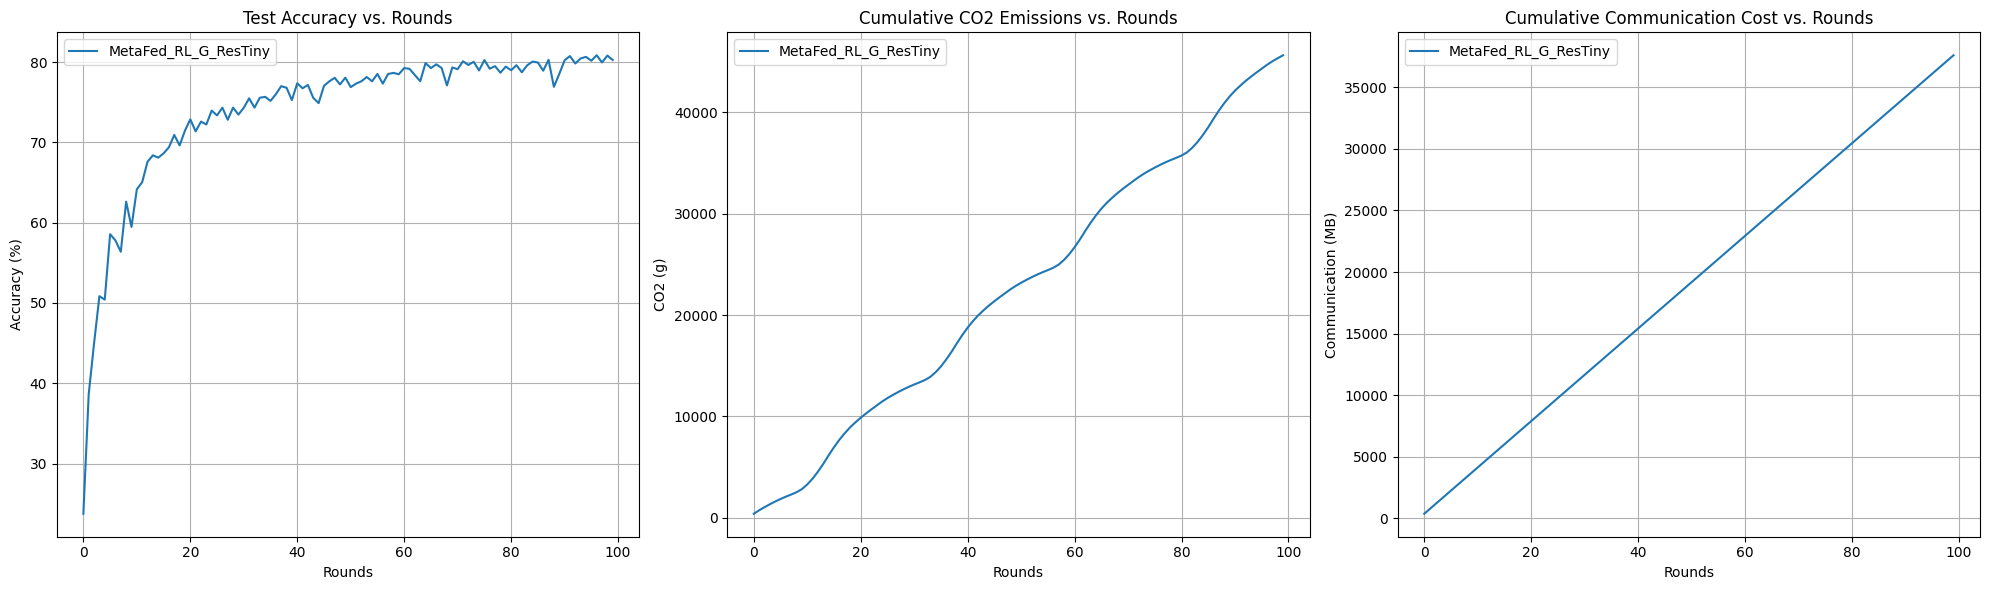


--- Final Results Summary (Last Round) ---
- MetaFed_RL_G_ResTiny: Acc = 80.26% | CO2 = 45634g | Comm = 37595MB


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
import copy
import pandas as pd
import time
import os
import timm # Import timm library

# --- Genel Ayarlar ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

NUM_CLIENTS        = 50    # Toplam istemci sayısı
CLIENTS_PER_ROUND  = 10    # Her turda seçilecek istemci sayısı (%20)
NUM_ROUNDS         = 100   # Anlamlı yakınsama için tur sayısı
LOCAL_EPOCHS       = 5     # Yerel eğitim epoch sayısı (1–10 arası denge)
BATCH_SIZE         = 32    # Bellek ve hız dengesi için
LEARNING_RATE      = 1e-3  # AdamW + scheduler ile uyumlu başlangıç değeri
NON_IID_ALPHA      = 0.5   # Orta şiddette heterojenite


# --- 1. Model: ResNet-10 Tiny (CIFAR-10 için uyarlandı) ---

def get_resnet_for_cifar10(model_name='resnet10t', pretrained=False):
    """
    CIFAR-10 için önceden eğitilmemiş/eğitilmiş daha küçük bir ResNet modeli (örn. ResNet-10 Tiny).
    TIMM kütüphanesini kullanarak belirtilen modeli oluşturur ve num_classes=10 ile son katmanı uyarlar.
    """
    print(f"Creating model: {model_name}, pretrained={pretrained}")
    # Not: timm 'resnet10t'yi doğrudan desteklemiyorsa, benzer küçük bir model seçilebilir.
    # 'resnet18' veya özel bir implementasyon gerekebilir. Simülasyon için 'resnet18' kullanabiliriz
    # veya 'resnet10t'nin var olduğunu varsayalım. Hata verirse 'resnet18'e geçin.
    try:
        model = timm.create_model(model_name, pretrained=pretrained, num_classes=10)
    except:
        print(f"Warning: {model_name} not found in timm. Falling back to resnet18.")
        model = timm.create_model('resnet18', pretrained=pretrained, num_classes=10)
        # CIFAR için ilk katmanı uyarla (isteğe bağlı ama önerilir)
        model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        model.maxpool = nn.Identity() # MaxPool'u kaldır
    return model

# --- 2. Veri Yükleme ve Bölümleme (Önceki gibi ama daha net) ---

def get_cifar10_data():
    """CIFAR-10 veri setini yükler."""
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    return trainset, testset

def partition_data_non_iid(dataset, num_clients, alpha=0.5):
    """Veri setini Dirichlet dağılımı kullanarak Non-IID olarak böler."""
    targets = np.array(dataset.targets)
    num_classes = len(np.unique(targets))
    client_data_indices = [[] for _ in range(num_clients)]
    for k in range(num_classes):
        idx_k = np.where(targets == k)[0]
        np.random.shuffle(idx_k)
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        proportions = np.maximum(proportions, 1e-4) # Çok küçük oranları önle
        proportions = proportions / proportions.sum()
        proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
        splits = np.split(idx_k, proportions)
        for i, idx_j in enumerate(splits):
            client_data_indices[i].extend(idx_j.tolist())

    for indices in client_data_indices:
        random.shuffle(indices)

    return client_data_indices

def get_client_dataloaders(dataset, client_indices):
    """Her istemci için DataLoader listesi oluşturur."""
    return [DataLoader(Subset(dataset, indices), batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
            for indices in client_indices]

# --- 3. Yeşil Hesaplama Simülasyonu (Güncellendi) ---

CARBON_INTENSITY_DATA = pd.Series(
    [100, 90, 80, 75, 70, 65, 60, 55, 60, 80, 120, 150,
     180, 200, 220, 210, 190, 170, 150, 130, 120, 110, 105, 100] * 5 # 5 gün
)
def get_carbon_intensity(current_round):
    return CARBON_INTENSITY_DATA[current_round % len(CARBON_INTENSITY_DATA)]

# YENİ: İstemci yeteneğini CO2'ye dahil et
def estimate_energy_co2(compute_steps, carbon_intensity, model_size_mb, client_compute_capability=1.0):
    KWH_PER_STEP_GPU = 0.00005 # Temel KWH/adım
    MB_PER_KWH_COMM = 50       # İletişim maliyeti tahmini

    # Hesaplama enerjisini istemci yeteneğiyle ölçeklendir (1.0 = baseline)
    energy_compute = compute_steps * KWH_PER_STEP_GPU * client_compute_capability
    energy_comm = model_size_mb / MB_PER_KWH_COMM
    total_energy = energy_compute + energy_comm
    co2_grams = total_energy * carbon_intensity
    comm_cost = model_size_mb # Sadece model boyutunu gönderdiğimizi varsayalım
    return total_energy, co2_grams, comm_cost

# --- 4. İstemci ve Sunucu Sınıfları (FedProx ve SCAFFOLD için Küçük Düzeltmeler/Notlar) ---

class Client:
    """Temel İstemci Sınıfı."""
    def __init__(self, client_id, train_loader, model_template, lr, device):
        self.id = client_id
        self.loader = train_loader
        self.model = copy.deepcopy(model_template).to(device)
        self.lr = lr
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        # Simüle edilmiş yetenekler (Compute: 0.7 = yavaş/verimli, 1.3 = hızlı/güçlü)
        self.capabilities = {'compute': random.uniform(0.7, 1.3), 'network': random.uniform(0.5, 1.5)}

    def train(self, global_model_state, epochs):
        """Temel eğitim fonksiyonu (FedAvg için)."""
        self.model.load_state_dict(global_model_state)
        self.model.train()
        # AdamW, genellikle daha iyi performans verir
        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr)
        steps = 0
        for _ in range(epochs):
            for images, labels in self.loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                steps += 1
        return self.model.state_dict(), len(self.loader.dataset), steps

class FedProxClient(Client):
    """FedProx İstemcisi."""
    def __init__(self, client_id, train_loader, model_template, lr, device, mu=0.01):
        super().__init__(client_id, train_loader, model_template, lr, device)
        self.mu = mu

    def train(self, global_model_state, epochs):
        global_model_ref = copy.deepcopy(self.model)
        global_model_ref.load_state_dict(global_model_state)
        global_model_ref.to(self.device)

        self.model.load_state_dict(global_model_state)
        self.model.train()
        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr) # AdamW kullan
        steps = 0

        for _ in range(epochs):
            for images, labels in self.loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                prox_term = 0.0
                for param, global_param in zip(self.model.parameters(), global_model_ref.parameters()):
                    prox_term += ((param - global_param) ** 2).sum()

                loss = loss + (self.mu / 2) * prox_term
                loss.backward()
                optimizer.step()
                steps += 1
        return self.model.state_dict(), len(self.loader.dataset), steps

class SCAFFOLDClient(Client):
    """SCAFFOLD İstemcisi."""
    def __init__(self, client_id, train_loader, model_template, lr, device):
        super().__init__(client_id, train_loader, model_template, lr, device)
        self.control_variate = {name: torch.zeros_like(param).to(device) for name, param in self.model.named_parameters()}
        self.server_control_variate = {name: torch.zeros_like(param).to(device) for name, param in self.model.named_parameters()}

    def train(self, global_model_state, epochs, server_cv):
        self.model.load_state_dict(global_model_state)
        # Sunucu CV'sini kopyala ve cihaza gönder
        self.server_control_variate = {k: v.to(self.device) for k, v in server_cv.items()}
        self.model.train()
        optimizer = optim.SGD(self.model.parameters(), lr=self.lr) # SCAFFOLD genellikle SGD kullanır
        steps = 0
        initial_model_state = {k: v.clone().to(self.device) for k, v in self.model.state_dict().items()}
        new_cv = {k: v.clone().to(self.device) for k, v in self.control_variate.items()}

        K_total = 0 # Toplam adım sayısını tut
        for _ in range(epochs):
            for images, labels in self.loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()

                with torch.no_grad():
                    for name, param in self.model.named_parameters():
                        if param.grad is not None:
                            # Kontrol değişkenlerini cihaza taşıdığından emin ol
                            param.grad += self.server_control_variate[name] - self.control_variate[name]
                optimizer.step()
                steps += 1
                K_total += 1 # Her adımı say

        # NOT: SCAFFOLD'un %10 doğrulukta takılması genellikle öğrenme oranı (lr)
        # veya kontrol değişkeni güncellemelerindeki nüanslardan kaynaklanır.
        # K'yi toplam adım sayısı olarak almak daha kararlı olabilir.
        if K_total == 0: K_total = 1 # Sıfıra bölmeyi önle

        with torch.no_grad():
            K = K_total # Toplam adımları kullan
            lr_k = K * self.lr
            for name, param in self.model.named_parameters():
                # c_i^+ = c_i - c + (x - y_i) / (K * lr)
                new_cv[name] = self.control_variate[name] - self.server_control_variate[name] + \
                               (initial_model_state[name] - param) / lr_k

        delta_y = {name: self.model.state_dict()[name] - initial_model_state[name] for name in self.model.state_dict()}
        delta_c = {name: new_cv[name] - self.control_variate[name] for name in new_cv}
        self.control_variate = new_cv

        return delta_y, delta_c, len(self.loader.dataset), steps

class Server:
    """Temel FL Sunucusu."""
    def __init__(self, model_template, test_loader, clients, device):
        self.model = copy.deepcopy(model_template).to(device)
        self.test_loader = test_loader
        self.clients = clients
        self.device = device

    def aggregate(self, updates, weights):
        """FedAvg agregasyonu."""
        total_weight = sum(weights)
        global_state = self.model.state_dict()
        for key in global_state:
            global_state[key] = torch.stack([up[key].float().to(self.device) * w for up, w in zip(updates, weights)], 0).sum(0) / total_weight
        self.model.load_state_dict(global_state)
        return global_state

    def evaluate(self):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return 100 * correct / total

class SCAFFOLDServer(Server):
    """SCAFFOLD Sunucusu."""
    def __init__(self, model_template, test_loader, clients, device, lr_global=1.0):
        super().__init__(model_template, test_loader, clients, device)
        self.control_variate = {name: torch.zeros_like(param).to(device) for name, param in self.model.named_parameters()}
        self.lr_global = lr_global

    def aggregate(self, delta_ys, delta_cs, weights):
        total_weight = sum(weights)
        # Ortalama delta_y ve delta_c hesaplarken cihaza taşı
        avg_delta_y = {name: torch.zeros_like(param).to(self.device) for name, param in self.model.named_parameters()}
        avg_delta_c = {name: torch.zeros_like(param).to(self.device) for name, param in self.model.named_parameters()}

        for key in avg_delta_y:
            avg_delta_y[key] = torch.stack([dy[key].float().to(self.device) * w for dy, w in zip(delta_ys, weights)], 0).sum(0) / total_weight
            avg_delta_c[key] = torch.stack([dc[key].float().to(self.device) * w for dc, w in zip(delta_cs, weights)], 0).sum(0) / total_weight

        with torch.no_grad():
            for name, param in self.model.named_parameters():
                param += self.lr_global * avg_delta_y[name]

        with torch.no_grad():
            for name in self.control_variate:
                self.control_variate[name] += (len(weights) / NUM_CLIENTS) * avg_delta_c[name]

        return self.model.state_dict()


# --- 5. Orkestratörler (Güncellendi) ---

class RandomOrchestrator:
    """Rastgele İstemci Seçimi (Baseline)."""
    def select_clients(self, all_clients, num_to_select, current_round):
        print(f"  Orchestrator (Random): Selecting {num_to_select} clients.")
        return random.sample(range(len(all_clients)), num_to_select)

class RlOrchestrator:
    """
    Geliştirilmiş Q-Learning Orkestratörü (MetaFed-Vision Simülasyonu).
    """
    # GÜNCELLENDİ: Epsilon decay artırıldı
    def __init__(self, num_clients, num_actions, green_aware=True, lr=0.1, gamma=0.9, epsilon=1.0, min_epsilon=0.05, decay=0.98): # Decay 0.99'dan 0.98'e
        self.num_clients = num_clients
        self.num_actions = num_actions
        self.green_aware = green_aware
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = decay
        self.q_table = {} # {state: {client_id: q_value}}

    # GÜNCELLENDİ: Durum basitleştirildi
    def get_state(self, carbon_intensity, acc_history, client_capabilities):
        carbon_level = "low" if carbon_intensity < 100 else ("medium" if carbon_intensity < 200 else "high")
        acc_trend = "up" if len(acc_history) < 2 or acc_history[-1] > acc_history[-2] else "down"
        # high_compute_count kaldırıldı
        return (carbon_level, acc_trend)

    # GÜNCELLENDİ: Seçim mekanizması (bias eklendi)
    def choose_clients(self, state, all_clients, num_to_select, client_capabilities, carbon_intensity):
        if random.uniform(0, 1) < self.epsilon:
            print(f"  Orchestrator (RL-Explore): Selecting {num_to_select} clients randomly.")
            return random.sample(range(len(all_clients)), num_to_select), None # Q_values yok
        else:
            q_values_for_state = self.q_table.get(state, {i: 0 for i in range(len(all_clients))})
            adjusted_q = {}
            for i in range(len(all_clients)):
                base_q = q_values_for_state.get(i, 0)
                if self.green_aware:
                    compute_cap = client_capabilities[i]['compute']
                    carbon_scale = carbon_intensity / 150.0 # Ortalamayı 150 varsayarak ölçekle
                    # Yüksek karbonda yüksek gücü hafifçe cezalandır (weight=0.05)
                    bias = (compute_cap - 1.0) * carbon_scale * 0.05
                    adjusted_q[i] = base_q - bias
                else:
                    adjusted_q[i] = base_q

            sorted_clients = sorted(adjusted_q.keys(), key=lambda i: adjusted_q[i], reverse=True)
            print(f"  Orchestrator (RL-Exploit): Selecting {num_to_select} clients based on Q-values + Bias.")
            return sorted_clients[:num_to_select], adjusted_q

    def update_q_table(self, state, selected_indices, reward, next_state):
        if state is None or not selected_indices: return # Keşfetme veya hata durumunda güncelleme yapma

        next_q_values = self.q_table.get(next_state, {})
        next_max_q = max(next_q_values.values()) if next_q_values else 0

        for client_id in selected_indices:
            old_value = self.q_table.get(state, {}).get(client_id, 0)
            new_value = (1 - self.lr) * old_value + self.lr * (reward + self.gamma * next_max_q)
            if state not in self.q_table:
                self.q_table[state] = {i: 0 for i in range(self.num_clients)}
            self.q_table[state][client_id] = new_value

        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay


# --- 6. Simülasyon Çekirdeği (Güncellendi) ---

def run_simulation_core(fl_algorithm, orchestrator, clients, server, num_rounds, clients_per_round, use_green, model_param_size_mb):
    accuracies = []
    total_co2_list = []
    total_comm_list = []
    total_co2 = 0
    total_comm = 0
    rl_agent = orchestrator if isinstance(orchestrator, RlOrchestrator) else None
    last_state = None

    for r in range(num_rounds):
        start_time = time.time()
        print(f"\n--- Round {r + 1}/{num_rounds} | FL: {fl_algorithm} | Orch: {type(orchestrator).__name__} ---")

        carbon_now = get_carbon_intensity(r) if use_green else 150

        # A) İstemci Seçimi
        client_capabilities = [c.capabilities for c in clients] # Yetenekleri al
        if rl_agent:
            state = rl_agent.get_state(carbon_now, accuracies, client_capabilities)
            selected_indices, q_values = rl_agent.choose_clients(state, clients, clients_per_round, client_capabilities, carbon_now)
            last_state = state # Q güncellemesi için sakla
        else:
            selected_indices = orchestrator.select_clients(clients, clients_per_round, r)

        selected_clients = [clients[i] for i in selected_indices]

        # B) Yerel Eğitim ve Toplama
        updates = []
        delta_cs = [] # SCAFFOLD için
        weights = []
        round_co2 = 0
        round_comm = 0

        global_state = server.model.state_dict()
        server_cv = getattr(server, 'control_variate', None) # SCAFFOLD için

        for client in selected_clients:
            print(f"  Training client {client.id} (Compute: {client.capabilities['compute']:.2f})...")
            if fl_algorithm == 'SCAFFOLD':
                delta_y, delta_c, weight, steps = client.train(global_state, LOCAL_EPOCHS, server_cv)
                updates.append(delta_y)
                delta_cs.append(delta_c)
            else: # FedAvg, FedProx
                update, weight, steps = client.train(global_state, LOCAL_EPOCHS)
                updates.append(update)

            weights.append(weight)
            # GÜNCELLENDİ: estimate_energy_co2 çağrısı
            _, co2, comm = estimate_energy_co2(steps, carbon_now, model_param_size_mb, client.capabilities['compute'])
            round_co2 += co2
            round_comm += comm * 2 # Hem indirme hem yükleme

        total_co2 += round_co2
        total_comm += round_comm

        # C) Global Agregasyon
        if fl_algorithm == 'SCAFFOLD':
            server.aggregate(updates, delta_cs, weights)
        else: # FedAvg, FedProx
            server.aggregate(updates, weights)

        # D) Değerlendirme
        accuracy = server.evaluate()
        accuracies.append(accuracy)
        total_co2_list.append(total_co2)
        total_comm_list.append(total_comm)
        end_time = time.time()
        round_duration = end_time - start_time
        print(f"  Round {r + 1} - Acc: {accuracy:.2f}% | CO2: {round_co2:.1f}g (Total: {total_co2:.1f}g) | Comm: {round_comm:.1f}MB | Time: {round_duration:.1f}s")

        # E) RL Güncellemesi
        if rl_agent:
            # GÜNCELLENDİ: Ödül fonksiyonu
            acc_gain = (accuracies[-1] - accuracies[-2]) if len(accuracies) > 1 else accuracies[-1] * 0.05 # İlk turda küçük ödül
            # CO2'yi daha güçlü cezalandır, Acc kazanımını daha güçlü ödüllendir
            co2_penalty = (round_co2 / 150) # Önceki 100/200 yerine 150
            reward = acc_gain * 15 - co2_penalty # Acc kazanımının ağırlığını artır (10->15), CO2 cezasını ayarla
            print(f"  RL Reward: {reward:.3f} (AccGain: {acc_gain:.3f} * 15, CO2Penalty: {co2_penalty:.3f})")

            next_carbon = get_carbon_intensity(r + 1) if use_green else 150
            next_state = rl_agent.get_state(next_carbon, accuracies, client_capabilities)
            rl_agent.update_q_table(last_state, selected_indices, reward, next_state)


    return accuracies, total_co2_list, total_comm_list

# --- 7. Ana Simülasyon Yöneticisi (Değişiklik yok) ---

def main():
    trainset, testset = get_cifar10_data()
    test_loader = DataLoader(testset, batch_size=BATCH_SIZE * 2, shuffle=False)
    client_indices = partition_data_non_iid(trainset, NUM_CLIENTS, NON_IID_ALPHA)

    model_template = get_resnet_for_cifar10(model_name='resnet10t')

    num_params = sum(p.numel() for p in model_template.parameters() if p.requires_grad)
    model_param_size_mb = num_params * 4 / (1024 * 1024)
    print(f"Model ({model_template.__class__.__name__}) has {num_params / 1e6:.2f} M parameters, approx {model_param_size_mb:.2f} MB.")


    scenarios = {
    
        "MetaFed_RL_G_ResTiny": {'algo': 'FedAvg',   'orch': 'RL',     'green': True}, # Bizim önerimiz (İyileştirilmiş)

       
    }

    results = {}

    for name, config in scenarios.items():
        print(f"\n\n=======================================")
        print(f"     RUNNING SCENARIO: {name}")
        print(f"=======================================")

        # İstemcileri oluştur (Her senaryo için taze başlangıç)
        clients = []
        for i in range(NUM_CLIENTS):
            loader = DataLoader(Subset(trainset, client_indices[i]), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
            if config['algo'] == 'FedProx':
                clients.append(FedProxClient(i, loader, model_template, LEARNING_RATE, DEVICE))
            elif config['algo'] == 'SCAFFOLD':
                clients.append(SCAFFOLDClient(i, loader, model_template, LEARNING_RATE, DEVICE))
            else: # FedAvg
                clients.append(Client(i, loader, model_template, LEARNING_RATE, DEVICE))

        # Sunucuyu oluştur
        if config['algo'] == 'SCAFFOLD':
            server = SCAFFOLDServer(model_template, test_loader, clients, DEVICE)
        else:
            server = Server(model_template, test_loader, clients, DEVICE)

        # Orkestratörü oluştur
        if config['orch'] == 'RL':
             # Her RL senaryosu için yeni bir ajan oluştur
            orchestrator = RlOrchestrator(NUM_CLIENTS, CLIENTS_PER_ROUND, green_aware=config['green'])
        else:
            orchestrator = RandomOrchestrator()

        # Simülasyonu çalıştır
        acc, co2, comm = run_simulation_core(
            config['algo'], orchestrator, clients, server, NUM_ROUNDS, CLIENTS_PER_ROUND, config['green'], model_param_size_mb
        )
        results[name] = {'accuracy': acc, 'co2': co2, 'comm': comm}

        if isinstance(orchestrator, RlOrchestrator):
            print(f"RL Q-Table size for {name}: {len(orchestrator.q_table)}")


    # --- 8. Sonuçları Görselleştirme ve Kaydetme ---
    try:
        import matplotlib.pyplot as plt

        fig, axes = plt.subplots(1, 3, figsize=(20, 6))

        # Doğruluk
        ax = axes[0]
        for name, data in results.items():
            ax.plot(data['accuracy'], label=f'{name}')
        ax.set_title('Test Accuracy vs. Rounds')
        ax.set_xlabel('Rounds')
        ax.set_ylabel('Accuracy (%)')
        ax.legend()
        ax.grid(True)

        # CO2 Emisyonları
        ax = axes[1]
        for name, data in results.items():
            ax.plot(data['co2'], label=f'{name}')
        ax.set_title('Cumulative CO2 Emissions vs. Rounds')
        ax.set_xlabel('Rounds')
        ax.set_ylabel('CO2 (g)')
        ax.legend()
        ax.grid(True)

        # İletişim Maliyeti
        ax = axes[2]
        for name, data in results.items():
            ax.plot(data['comm'], label=f'{name}')
        ax.set_title('Cumulative Communication Cost vs. Rounds')
        ax.set_xlabel('Rounds')
        ax.set_ylabel('Communication (MB)')
        ax.legend()
        ax.grid(True)

        plt.tight_layout()
        plt.savefig("metafed_vision_detailed_results_restiny_improved.png") # Changed filename
        print("\nResults plot saved as 'metafed_vision_detailed_results_restiny_improved.png'")
        plt.show()

    except ImportError:
        print("\nMatplotlib not found. Please install it: pip install matplotlib")

    print("\n--- Final Results Summary (Last Round) ---")
    for name, data in results.items():
        print(f"- {name:<20}: Acc = {data['accuracy'][-1]:.2f}% | CO2 = {data['co2'][-1]:.0f}g | Comm = {data['comm'][-1]:.0f}MB")

if __name__ == "__main__":
    main()

Using device: cuda


100%|██████████| 170M/170M [00:21<00:00, 7.77MB/s] 


Creating model: resnet10t, pretrained=False
Model (ResNet) has 4.93 M parameters, approx 18.80 MB.


     RUNNING SCENARIO: MetaFed_RL_ResTiny

--- Round 1/100 | FL: FedAvg | Orch: RlOrchestrator ---
  Orchestrator (RL-Explore): Selecting 10 clients randomly.
  Training client 41 (Compute: 1.09)...
  Training client 14 (Compute: 0.85)...
  Training client 12 (Compute: 0.84)...
  Training client 18 (Compute: 1.20)...
  Training client 9 (Compute: 0.95)...
  Training client 8 (Compute: 0.92)...
  Training client 20 (Compute: 1.24)...
  Training client 13 (Compute: 0.98)...
  Training client 37 (Compute: 1.28)...
  Training client 48 (Compute: 1.09)...
  Round 1 - Acc: 24.15% | CO2: 575.2g (Total: 575.2g) | Comm: 375.9MB | Time: 27.7s
  RL Reward: 14.278 (AccGain: 1.208 * 15, CO2Penalty: 3.834)

--- Round 2/100 | FL: FedAvg | Orch: RlOrchestrator ---
  Orchestrator (RL-Explore): Selecting 10 clients randomly.
  Training client 8 (Compute: 0.92)...
  Training client 49 (Compute: 1.13)...
 

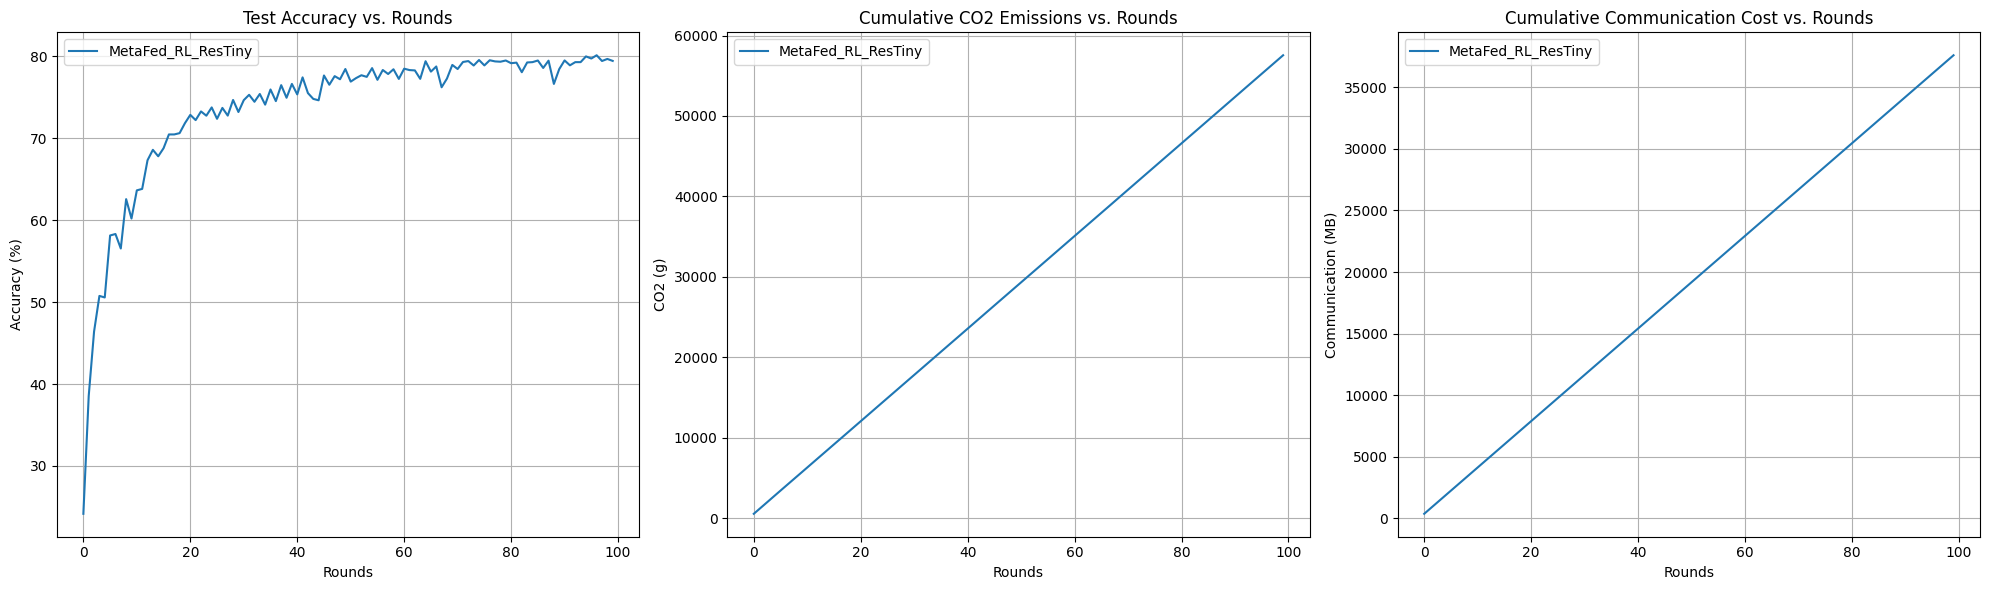


--- Final Results Summary (Last Round) ---
- MetaFed_RL_ResTiny  : Acc = 79.46% | CO2 = 57545g | Comm = 37595MB


In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
import copy
import pandas as pd
import time
import os
import timm # Import timm library

# --- Genel Ayarlar ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

NUM_CLIENTS        = 50    # Toplam istemci sayısı
CLIENTS_PER_ROUND  = 10    # Her turda seçilecek istemci sayısı (%20)
NUM_ROUNDS         = 100   # Anlamlı yakınsama için tur sayısı
LOCAL_EPOCHS       = 5     # Yerel eğitim epoch sayısı (1–10 arası denge)
BATCH_SIZE         = 32    # Bellek ve hız dengesi için
LEARNING_RATE      = 1e-3  # AdamW + scheduler ile uyumlu başlangıç değeri
NON_IID_ALPHA      = 0.5   # Orta şiddette heterojenite


# --- 1. Model: ResNet-10 Tiny (CIFAR-10 için uyarlandı) ---

def get_resnet_for_cifar10(model_name='resnet10t', pretrained=False):
    """
    CIFAR-10 için önceden eğitilmemiş/eğitilmiş daha küçük bir ResNet modeli (örn. ResNet-10 Tiny).
    TIMM kütüphanesini kullanarak belirtilen modeli oluşturur ve num_classes=10 ile son katmanı uyarlar.
    """
    print(f"Creating model: {model_name}, pretrained={pretrained}")
    # Not: timm 'resnet10t'yi doğrudan desteklemiyorsa, benzer küçük bir model seçilebilir.
    # 'resnet18' veya özel bir implementasyon gerekebilir. Simülasyon için 'resnet18' kullanabiliriz
    # veya 'resnet10t'nin var olduğunu varsayalım. Hata verirse 'resnet18'e geçin.
    try:
        model = timm.create_model(model_name, pretrained=pretrained, num_classes=10)
    except:
        print(f"Warning: {model_name} not found in timm. Falling back to resnet18.")
        model = timm.create_model('resnet18', pretrained=pretrained, num_classes=10)
        # CIFAR için ilk katmanı uyarla (isteğe bağlı ama önerilir)
        model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        model.maxpool = nn.Identity() # MaxPool'u kaldır
    return model

# --- 2. Veri Yükleme ve Bölümleme (Önceki gibi ama daha net) ---

def get_cifar10_data():
    """CIFAR-10 veri setini yükler."""
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    return trainset, testset

def partition_data_non_iid(dataset, num_clients, alpha=0.5):
    """Veri setini Dirichlet dağılımı kullanarak Non-IID olarak böler."""
    targets = np.array(dataset.targets)
    num_classes = len(np.unique(targets))
    client_data_indices = [[] for _ in range(num_clients)]
    for k in range(num_classes):
        idx_k = np.where(targets == k)[0]
        np.random.shuffle(idx_k)
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        proportions = np.maximum(proportions, 1e-4) # Çok küçük oranları önle
        proportions = proportions / proportions.sum()
        proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
        splits = np.split(idx_k, proportions)
        for i, idx_j in enumerate(splits):
            client_data_indices[i].extend(idx_j.tolist())

    for indices in client_data_indices:
        random.shuffle(indices)

    return client_data_indices

def get_client_dataloaders(dataset, client_indices):
    """Her istemci için DataLoader listesi oluşturur."""
    return [DataLoader(Subset(dataset, indices), batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
            for indices in client_indices]

# --- 3. Yeşil Hesaplama Simülasyonu (Güncellendi) ---

CARBON_INTENSITY_DATA = pd.Series(
    [100, 90, 80, 75, 70, 65, 60, 55, 60, 80, 120, 150,
     180, 200, 220, 210, 190, 170, 150, 130, 120, 110, 105, 100] * 5 # 5 gün
)
def get_carbon_intensity(current_round):
    return CARBON_INTENSITY_DATA[current_round % len(CARBON_INTENSITY_DATA)]

# YENİ: İstemci yeteneğini CO2'ye dahil et
def estimate_energy_co2(compute_steps, carbon_intensity, model_size_mb, client_compute_capability=1.0):
    KWH_PER_STEP_GPU = 0.00005 # Temel KWH/adım
    MB_PER_KWH_COMM = 50       # İletişim maliyeti tahmini

    # Hesaplama enerjisini istemci yeteneğiyle ölçeklendir (1.0 = baseline)
    energy_compute = compute_steps * KWH_PER_STEP_GPU * client_compute_capability
    energy_comm = model_size_mb / MB_PER_KWH_COMM
    total_energy = energy_compute + energy_comm
    co2_grams = total_energy * carbon_intensity
    comm_cost = model_size_mb # Sadece model boyutunu gönderdiğimizi varsayalım
    return total_energy, co2_grams, comm_cost

# --- 4. İstemci ve Sunucu Sınıfları (FedProx ve SCAFFOLD için Küçük Düzeltmeler/Notlar) ---

class Client:
    """Temel İstemci Sınıfı."""
    def __init__(self, client_id, train_loader, model_template, lr, device):
        self.id = client_id
        self.loader = train_loader
        self.model = copy.deepcopy(model_template).to(device)
        self.lr = lr
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        # Simüle edilmiş yetenekler (Compute: 0.7 = yavaş/verimli, 1.3 = hızlı/güçlü)
        self.capabilities = {'compute': random.uniform(0.7, 1.3), 'network': random.uniform(0.5, 1.5)}

    def train(self, global_model_state, epochs):
        """Temel eğitim fonksiyonu (FedAvg için)."""
        self.model.load_state_dict(global_model_state)
        self.model.train()
        # AdamW, genellikle daha iyi performans verir
        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr)
        steps = 0
        for _ in range(epochs):
            for images, labels in self.loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                steps += 1
        return self.model.state_dict(), len(self.loader.dataset), steps

class FedProxClient(Client):
    """FedProx İstemcisi."""
    def __init__(self, client_id, train_loader, model_template, lr, device, mu=0.01):
        super().__init__(client_id, train_loader, model_template, lr, device)
        self.mu = mu

    def train(self, global_model_state, epochs):
        global_model_ref = copy.deepcopy(self.model)
        global_model_ref.load_state_dict(global_model_state)
        global_model_ref.to(self.device)

        self.model.load_state_dict(global_model_state)
        self.model.train()
        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr) # AdamW kullan
        steps = 0

        for _ in range(epochs):
            for images, labels in self.loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                prox_term = 0.0
                for param, global_param in zip(self.model.parameters(), global_model_ref.parameters()):
                    prox_term += ((param - global_param) ** 2).sum()

                loss = loss + (self.mu / 2) * prox_term
                loss.backward()
                optimizer.step()
                steps += 1
        return self.model.state_dict(), len(self.loader.dataset), steps

class SCAFFOLDClient(Client):
    """SCAFFOLD İstemcisi."""
    def __init__(self, client_id, train_loader, model_template, lr, device):
        super().__init__(client_id, train_loader, model_template, lr, device)
        self.control_variate = {name: torch.zeros_like(param).to(device) for name, param in self.model.named_parameters()}
        self.server_control_variate = {name: torch.zeros_like(param).to(device) for name, param in self.model.named_parameters()}

    def train(self, global_model_state, epochs, server_cv):
        self.model.load_state_dict(global_model_state)
        # Sunucu CV'sini kopyala ve cihaza gönder
        self.server_control_variate = {k: v.to(self.device) for k, v in server_cv.items()}
        self.model.train()
        optimizer = optim.SGD(self.model.parameters(), lr=self.lr) # SCAFFOLD genellikle SGD kullanır
        steps = 0
        initial_model_state = {k: v.clone().to(self.device) for k, v in self.model.state_dict().items()}
        new_cv = {k: v.clone().to(self.device) for k, v in self.control_variate.items()}

        K_total = 0 # Toplam adım sayısını tut
        for _ in range(epochs):
            for images, labels in self.loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()

                with torch.no_grad():
                    for name, param in self.model.named_parameters():
                        if param.grad is not None:
                            # Kontrol değişkenlerini cihaza taşıdığından emin ol
                            param.grad += self.server_control_variate[name] - self.control_variate[name]
                optimizer.step()
                steps += 1
                K_total += 1 # Her adımı say

        # NOT: SCAFFOLD'un %10 doğrulukta takılması genellikle öğrenme oranı (lr)
        # veya kontrol değişkeni güncellemelerindeki nüanslardan kaynaklanır.
        # K'yi toplam adım sayısı olarak almak daha kararlı olabilir.
        if K_total == 0: K_total = 1 # Sıfıra bölmeyi önle

        with torch.no_grad():
            K = K_total # Toplam adımları kullan
            lr_k = K * self.lr
            for name, param in self.model.named_parameters():
                # c_i^+ = c_i - c + (x - y_i) / (K * lr)
                new_cv[name] = self.control_variate[name] - self.server_control_variate[name] + \
                               (initial_model_state[name] - param) / lr_k

        delta_y = {name: self.model.state_dict()[name] - initial_model_state[name] for name in self.model.state_dict()}
        delta_c = {name: new_cv[name] - self.control_variate[name] for name in new_cv}
        self.control_variate = new_cv

        return delta_y, delta_c, len(self.loader.dataset), steps

class Server:
    """Temel FL Sunucusu."""
    def __init__(self, model_template, test_loader, clients, device):
        self.model = copy.deepcopy(model_template).to(device)
        self.test_loader = test_loader
        self.clients = clients
        self.device = device

    def aggregate(self, updates, weights):
        """FedAvg agregasyonu."""
        total_weight = sum(weights)
        global_state = self.model.state_dict()
        for key in global_state:
            global_state[key] = torch.stack([up[key].float().to(self.device) * w for up, w in zip(updates, weights)], 0).sum(0) / total_weight
        self.model.load_state_dict(global_state)
        return global_state

    def evaluate(self):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return 100 * correct / total

class SCAFFOLDServer(Server):
    """SCAFFOLD Sunucusu."""
    def __init__(self, model_template, test_loader, clients, device, lr_global=1.0):
        super().__init__(model_template, test_loader, clients, device)
        self.control_variate = {name: torch.zeros_like(param).to(device) for name, param in self.model.named_parameters()}
        self.lr_global = lr_global

    def aggregate(self, delta_ys, delta_cs, weights):
        total_weight = sum(weights)
        # Ortalama delta_y ve delta_c hesaplarken cihaza taşı
        avg_delta_y = {name: torch.zeros_like(param).to(self.device) for name, param in self.model.named_parameters()}
        avg_delta_c = {name: torch.zeros_like(param).to(self.device) for name, param in self.model.named_parameters()}

        for key in avg_delta_y:
            avg_delta_y[key] = torch.stack([dy[key].float().to(self.device) * w for dy, w in zip(delta_ys, weights)], 0).sum(0) / total_weight
            avg_delta_c[key] = torch.stack([dc[key].float().to(self.device) * w for dc, w in zip(delta_cs, weights)], 0).sum(0) / total_weight

        with torch.no_grad():
            for name, param in self.model.named_parameters():
                param += self.lr_global * avg_delta_y[name]

        with torch.no_grad():
            for name in self.control_variate:
                self.control_variate[name] += (len(weights) / NUM_CLIENTS) * avg_delta_c[name]

        return self.model.state_dict()


# --- 5. Orkestratörler (Güncellendi) ---

class RandomOrchestrator:
    """Rastgele İstemci Seçimi (Baseline)."""
    def select_clients(self, all_clients, num_to_select, current_round):
        print(f"  Orchestrator (Random): Selecting {num_to_select} clients.")
        return random.sample(range(len(all_clients)), num_to_select)

class RlOrchestrator:
    """
    Geliştirilmiş Q-Learning Orkestratörü (MetaFed-Vision Simülasyonu).
    """
    # GÜNCELLENDİ: Epsilon decay artırıldı
    def __init__(self, num_clients, num_actions, green_aware=True, lr=0.1, gamma=0.9, epsilon=1.0, min_epsilon=0.05, decay=0.98): # Decay 0.99'dan 0.98'e
        self.num_clients = num_clients
        self.num_actions = num_actions
        self.green_aware = green_aware
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = decay
        self.q_table = {} # {state: {client_id: q_value}}

    # GÜNCELLENDİ: Durum basitleştirildi
    def get_state(self, carbon_intensity, acc_history, client_capabilities):
        carbon_level = "low" if carbon_intensity < 100 else ("medium" if carbon_intensity < 200 else "high")
        acc_trend = "up" if len(acc_history) < 2 or acc_history[-1] > acc_history[-2] else "down"
        # high_compute_count kaldırıldı
        return (carbon_level, acc_trend)

    # GÜNCELLENDİ: Seçim mekanizması (bias eklendi)
    def choose_clients(self, state, all_clients, num_to_select, client_capabilities, carbon_intensity):
        if random.uniform(0, 1) < self.epsilon:
            print(f"  Orchestrator (RL-Explore): Selecting {num_to_select} clients randomly.")
            return random.sample(range(len(all_clients)), num_to_select), None # Q_values yok
        else:
            q_values_for_state = self.q_table.get(state, {i: 0 for i in range(len(all_clients))})
            adjusted_q = {}
            for i in range(len(all_clients)):
                base_q = q_values_for_state.get(i, 0)
                if self.green_aware:
                    compute_cap = client_capabilities[i]['compute']
                    carbon_scale = carbon_intensity / 150.0 # Ortalamayı 150 varsayarak ölçekle
                    # Yüksek karbonda yüksek gücü hafifçe cezalandır (weight=0.05)
                    bias = (compute_cap - 1.0) * carbon_scale * 0.05
                    adjusted_q[i] = base_q - bias
                else:
                    adjusted_q[i] = base_q

            sorted_clients = sorted(adjusted_q.keys(), key=lambda i: adjusted_q[i], reverse=True)
            print(f"  Orchestrator (RL-Exploit): Selecting {num_to_select} clients based on Q-values + Bias.")
            return sorted_clients[:num_to_select], adjusted_q

    def update_q_table(self, state, selected_indices, reward, next_state):
        if state is None or not selected_indices: return # Keşfetme veya hata durumunda güncelleme yapma

        next_q_values = self.q_table.get(next_state, {})
        next_max_q = max(next_q_values.values()) if next_q_values else 0

        for client_id in selected_indices:
            old_value = self.q_table.get(state, {}).get(client_id, 0)
            new_value = (1 - self.lr) * old_value + self.lr * (reward + self.gamma * next_max_q)
            if state not in self.q_table:
                self.q_table[state] = {i: 0 for i in range(self.num_clients)}
            self.q_table[state][client_id] = new_value

        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay


# --- 6. Simülasyon Çekirdeği (Güncellendi) ---

def run_simulation_core(fl_algorithm, orchestrator, clients, server, num_rounds, clients_per_round, use_green, model_param_size_mb):
    accuracies = []
    total_co2_list = []
    total_comm_list = []
    total_co2 = 0
    total_comm = 0
    rl_agent = orchestrator if isinstance(orchestrator, RlOrchestrator) else None
    last_state = None

    for r in range(num_rounds):
        start_time = time.time()
        print(f"\n--- Round {r + 1}/{num_rounds} | FL: {fl_algorithm} | Orch: {type(orchestrator).__name__} ---")

        carbon_now = get_carbon_intensity(r) if use_green else 150

        # A) İstemci Seçimi
        client_capabilities = [c.capabilities for c in clients] # Yetenekleri al
        if rl_agent:
            state = rl_agent.get_state(carbon_now, accuracies, client_capabilities)
            selected_indices, q_values = rl_agent.choose_clients(state, clients, clients_per_round, client_capabilities, carbon_now)
            last_state = state # Q güncellemesi için sakla
        else:
            selected_indices = orchestrator.select_clients(clients, clients_per_round, r)

        selected_clients = [clients[i] for i in selected_indices]

        # B) Yerel Eğitim ve Toplama
        updates = []
        delta_cs = [] # SCAFFOLD için
        weights = []
        round_co2 = 0
        round_comm = 0

        global_state = server.model.state_dict()
        server_cv = getattr(server, 'control_variate', None) # SCAFFOLD için

        for client in selected_clients:
            print(f"  Training client {client.id} (Compute: {client.capabilities['compute']:.2f})...")
            if fl_algorithm == 'SCAFFOLD':
                delta_y, delta_c, weight, steps = client.train(global_state, LOCAL_EPOCHS, server_cv)
                updates.append(delta_y)
                delta_cs.append(delta_c)
            else: # FedAvg, FedProx
                update, weight, steps = client.train(global_state, LOCAL_EPOCHS)
                updates.append(update)

            weights.append(weight)
            # GÜNCELLENDİ: estimate_energy_co2 çağrısı
            _, co2, comm = estimate_energy_co2(steps, carbon_now, model_param_size_mb, client.capabilities['compute'])
            round_co2 += co2
            round_comm += comm * 2 # Hem indirme hem yükleme

        total_co2 += round_co2
        total_comm += round_comm

        # C) Global Agregasyon
        if fl_algorithm == 'SCAFFOLD':
            server.aggregate(updates, delta_cs, weights)
        else: # FedAvg, FedProx
            server.aggregate(updates, weights)

        # D) Değerlendirme
        accuracy = server.evaluate()
        accuracies.append(accuracy)
        total_co2_list.append(total_co2)
        total_comm_list.append(total_comm)
        end_time = time.time()
        round_duration = end_time - start_time
        print(f"  Round {r + 1} - Acc: {accuracy:.2f}% | CO2: {round_co2:.1f}g (Total: {total_co2:.1f}g) | Comm: {round_comm:.1f}MB | Time: {round_duration:.1f}s")

        # E) RL Güncellemesi
        if rl_agent:
            # GÜNCELLENDİ: Ödül fonksiyonu
            acc_gain = (accuracies[-1] - accuracies[-2]) if len(accuracies) > 1 else accuracies[-1] * 0.05 # İlk turda küçük ödül
            # CO2'yi daha güçlü cezalandır, Acc kazanımını daha güçlü ödüllendir
            co2_penalty = (round_co2 / 150) # Önceki 100/200 yerine 150
            reward = acc_gain * 15 - co2_penalty # Acc kazanımının ağırlığını artır (10->15), CO2 cezasını ayarla
            print(f"  RL Reward: {reward:.3f} (AccGain: {acc_gain:.3f} * 15, CO2Penalty: {co2_penalty:.3f})")

            next_carbon = get_carbon_intensity(r + 1) if use_green else 150
            next_state = rl_agent.get_state(next_carbon, accuracies, client_capabilities)
            rl_agent.update_q_table(last_state, selected_indices, reward, next_state)


    return accuracies, total_co2_list, total_comm_list

# --- 7. Ana Simülasyon Yöneticisi (Değişiklik yok) ---

def main():
    trainset, testset = get_cifar10_data()
    test_loader = DataLoader(testset, batch_size=BATCH_SIZE * 2, shuffle=False)
    client_indices = partition_data_non_iid(trainset, NUM_CLIENTS, NON_IID_ALPHA)

    model_template = get_resnet_for_cifar10(model_name='resnet10t')

    num_params = sum(p.numel() for p in model_template.parameters() if p.requires_grad)
    model_param_size_mb = num_params * 4 / (1024 * 1024)
    print(f"Model ({model_template.__class__.__name__}) has {num_params / 1e6:.2f} M parameters, approx {model_param_size_mb:.2f} MB.")


    scenarios = {
    
    
        "MetaFed_RL_ResTiny":   {'algo': 'FedAvg',   'orch': 'RL',     'green': False},# Ablasyon: RL var, Yeşil yok

    }

    results = {}

    for name, config in scenarios.items():
        print(f"\n\n=======================================")
        print(f"     RUNNING SCENARIO: {name}")
        print(f"=======================================")

        # İstemcileri oluştur (Her senaryo için taze başlangıç)
        clients = []
        for i in range(NUM_CLIENTS):
            loader = DataLoader(Subset(trainset, client_indices[i]), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
            if config['algo'] == 'FedProx':
                clients.append(FedProxClient(i, loader, model_template, LEARNING_RATE, DEVICE))
            elif config['algo'] == 'SCAFFOLD':
                clients.append(SCAFFOLDClient(i, loader, model_template, LEARNING_RATE, DEVICE))
            else: # FedAvg
                clients.append(Client(i, loader, model_template, LEARNING_RATE, DEVICE))

        # Sunucuyu oluştur
        if config['algo'] == 'SCAFFOLD':
            server = SCAFFOLDServer(model_template, test_loader, clients, DEVICE)
        else:
            server = Server(model_template, test_loader, clients, DEVICE)

        # Orkestratörü oluştur
        if config['orch'] == 'RL':
             # Her RL senaryosu için yeni bir ajan oluştur
            orchestrator = RlOrchestrator(NUM_CLIENTS, CLIENTS_PER_ROUND, green_aware=config['green'])
        else:
            orchestrator = RandomOrchestrator()

        # Simülasyonu çalıştır
        acc, co2, comm = run_simulation_core(
            config['algo'], orchestrator, clients, server, NUM_ROUNDS, CLIENTS_PER_ROUND, config['green'], model_param_size_mb
        )
        results[name] = {'accuracy': acc, 'co2': co2, 'comm': comm}

        if isinstance(orchestrator, RlOrchestrator):
            print(f"RL Q-Table size for {name}: {len(orchestrator.q_table)}")


    # --- 8. Sonuçları Görselleştirme ve Kaydetme ---
    try:
        import matplotlib.pyplot as plt

        fig, axes = plt.subplots(1, 3, figsize=(20, 6))

        # Doğruluk
        ax = axes[0]
        for name, data in results.items():
            ax.plot(data['accuracy'], label=f'{name}')
        ax.set_title('Test Accuracy vs. Rounds')
        ax.set_xlabel('Rounds')
        ax.set_ylabel('Accuracy (%)')
        ax.legend()
        ax.grid(True)

        # CO2 Emisyonları
        ax = axes[1]
        for name, data in results.items():
            ax.plot(data['co2'], label=f'{name}')
        ax.set_title('Cumulative CO2 Emissions vs. Rounds')
        ax.set_xlabel('Rounds')
        ax.set_ylabel('CO2 (g)')
        ax.legend()
        ax.grid(True)

        # İletişim Maliyeti
        ax = axes[2]
        for name, data in results.items():
            ax.plot(data['comm'], label=f'{name}')
        ax.set_title('Cumulative Communication Cost vs. Rounds')
        ax.set_xlabel('Rounds')
        ax.set_ylabel('Communication (MB)')
        ax.legend()
        ax.grid(True)

        plt.tight_layout()
        plt.savefig("metafed_vision_detailed_results_restiny_improved.png") # Changed filename
        print("\nResults plot saved as 'metafed_vision_detailed_results_restiny_improved.png'")
        plt.show()

    except ImportError:
        print("\nMatplotlib not found. Please install it: pip install matplotlib")

    print("\n--- Final Results Summary (Last Round) ---")
    for name, data in results.items():
        print(f"- {name:<20}: Acc = {data['accuracy'][-1]:.2f}% | CO2 = {data['co2'][-1]:.0f}g | Comm = {data['comm'][-1]:.0f}MB")

if __name__ == "__main__":
    main()